#  Track Analysis

In order to properly analyze our GPX tracks, we need to put all of them into the same _frame-of-reference_.   This is accomplished by creating a single route, then comparing all routes against that.

## Step 0: Globals

In [1]:
database_path = 'bike_data.db'

start_coord = (39.5989743, -104.8609468)
end_coord   = (39.75428108249532, -105.00085402872664)

epsg_code = 32613

## Step 1: Import Required Libraries

In [2]:
import pandas as pd
from sqlalchemy import create_engine
from pyproj import CRS, Proj, Transformer
import re, numpy as np
import plotly.graph_objects as go
import plotly.express as px
import matplotlib as mpl
from matplotlib import cm

### Step 2: Setup the database.

In [3]:
# SQLAlchemy connectable 
conn = create_engine( 'sqlite:///' + database_path ).connect()

#  For each segment, we need to create a track for each dataset
dataset_ids = pd.read_sql_query('SELECT DISTINCT datasetId FROM point_list', conn)

#  Load the Vertex List
vtx_list = pd.read_csv('cpp/release/waypoints.csv')

### Step 3: Setup UTM Coordinate Projection API

In [4]:
#  Setup the Projection Transformer
crs = CRS.from_epsg( epsg_code )
proj_dd2utm = Transformer.from_crs(crs.geodetic_crs, crs)
proj_utm2dd = Transformer.from_crs(crs, crs.geodetic_crs)
utm_zone = int(re.findall("\d+", crs.utm_zone)[0])
print('UTM Grid Zone: {}'.format(utm_zone))

(easting,northing) = proj_dd2utm.transform( start_coord[0], start_coord[1] )
start_coord_utm = np.array( [easting, northing], np.float64 )

UTM Grid Zone: 13


## Step 4: Visualize "Best-Fit" Routes from the GA

[[39.624743, 39.625959, 39.626914, 39.6274, 39.631437, 39.632385, 39.642401, 39.644721000000004], [-104.86833700000001, -104.867659, -104.86811100000001, -104.875603, -104.875724, -104.87755200000001, -104.87388600000001, -104.870525]]
[[39.624878, 39.626985999999995, 39.627227000000005, 39.627643, 39.627887, 39.631409999999995, 39.632376, 39.642256, 39.644614000000004], [-104.86811499999999, -104.86791299999999, -104.874123, -104.87543899999999, -104.875672, -104.875689, -104.877517, -104.87401399999999, -104.870747]]
[[39.644372, 39.632781, 39.627217, 39.627062, 39.627095000000004, 39.626003999999995, 39.624788, 39.627697, 39.627878, 39.628752], [-104.87265900000001, -104.877551, -104.873075, -104.871036, -104.868356, -104.867635, -104.86838300000001, -104.875427, -104.875672, -104.87570500000001]]
[[39.624752, 39.626013, 39.627005, 39.627255, 39.627851, 39.631454999999995, 39.632349, 39.642265, 39.643623999999996, 39.643975, 39.644721000000004], [-104.86831399999998, -104.8676469999

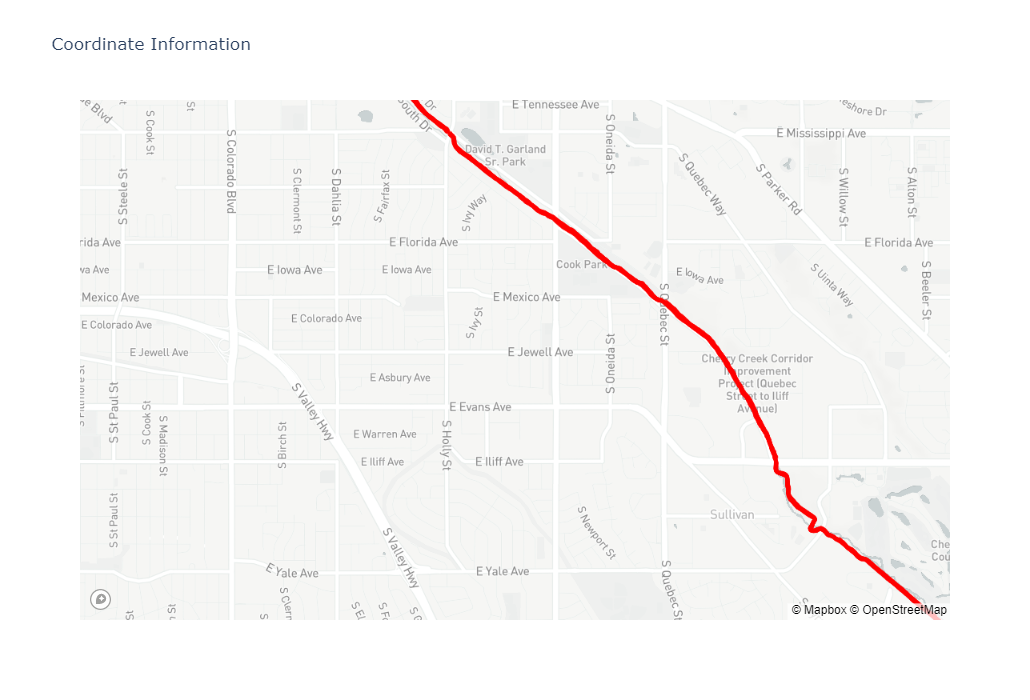

In [7]:
mapbox_access_token = open(".mapbox_token").read()

fig = go.Figure()

#  Add Points
sql_query = 'SELECT * FROM point_list ORDER BY timestamp'
full_points = pd.read_sql_query( sql_query, conn )
fig.add_trace(go.Scattermapbox(
        lat=full_points.loc[:,'latitude'],
        lon=full_points.loc[:,'longitude'],
        mode='markers',
        marker=go.scattermapbox.Marker( size=5,
                                        color='rgb(255, 0, 0)',
                                        opacity=0.7 )
    ))

centroid = [full_points.loc[:,'latitude'].mean(),
            full_points.loc[:,'longitude'].mean()]
fig.update_layout(
    title='Coordinate Information',
    autosize=True,
    hovermode='closest',
    showlegend=False,
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=centroid[0],
            lon=centroid[1]
        ),
        pitch=0,
        zoom=13,
        style='light'
    ),
    height=700,
)

#  Get the list of waypoint sizes
waypoint_sizes = vtx_list['NumWaypoints'].unique()
colors = {}
waypoints = {}
cmap = mpl.cm.get_cmap('Spectral')
for wp in waypoint_sizes:
    colors[wp] = cmap((wp - waypoint_sizes.min()) / (waypoint_sizes.max() - waypoint_sizes.min()))
    waypoints[wp] = [[],[]]
for wp in vtx_list.itertuples():
    waypoints[wp.NumWaypoints][0].append( wp.Latitude )
    waypoints[wp.NumWaypoints][1].append( wp.Longitude )
    
for wp in waypoints:
    fig.add_trace(go.Scattermapbox(
        lat=waypoints[wp][0],
        lon=waypoints[wp][1],
        mode='markers+lines',
        marker=go.scattermapbox.Marker( size=5,
                                        color=colors[wp],
                                        opacity=0.7 )
    ))
fig.show()

## Step 6: Iterate through each sector, constructing the path

In [6]:
# Get Sector List
sql_query = 'SELECT * FROM sector_list'
sector_table = pd.read_sql_query( sql_query, conn )

# Show the map


e_max_vals = { 'sector_0': 50,
               'sector_1': 327.708,
               'sector_2': 50,
               'sector_3': 50,
               'sector_4': 50,
               'sector_5': 50,
               'sector_6': 50,
               'sector_7': 50,
               'sector_8': 50 }
#  Iterate over each sector, building the route
for sector_id in ['sector_0']: #sector_table['sector_id']:
    
    # Get the route
    [spline_x_utm,spline_y_utm,spline_lats, spline_lons] = Process_Sector( sector_id, start_coord_utm, e_max_vals[sector_id] )
    print('Sector route has {} points'.format(len(spline_lats)))
    #  Plot the new points
    fig.add_trace(go.Scattermapbox(
        lat=spline_lats,
        lon=spline_lons,
        mode='markers+lines',
        marker=go.scattermapbox.Marker( size=5,
                                        color='rgb(0, 255, 0)',
                                        opacity=0.7 )
    ))
    
    #  Update the starting point
    start_coord_utm = [spline_x_utm[-1],
                       spline_y_utm[-1]]
    
fig.show()

NameError: name 'Process_Sector' is not defined